<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/TSAI_EVA4_S5_Model_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 3: Using GAP layer

#Target : 
- Lesser parameters <10K
- Test Accuracy ~99%
- ~15 Epochs 

#Results: 
- Parameters used : 6070
- Train Accuracy: 98.64%
- Test Accuracy : 98.47%

#Analysis - Observation :
- Stable model developed without any overfitting
- Model can be added with more layers and parameters to achieve higher accuracy

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26, RF= 3x3, step=1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24, RF=5x5, step=1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22, RF=7x7, step=1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11, RF=7x7, step=2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9, RF= 11, step=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7, RF=15, step=2

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7, RF= 15, step=2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1, RF = 27, step=2

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.3197238445281982 Batch_id=0 Accuracy=6.25:   0%|          | 1/938 [00:00<02:10,  7.17it/s]

EPOCH: 0


Loss=0.16083072125911713 Batch_id=937 Accuracy=87.23: 100%|██████████| 938/938 [01:55<00:00,  8.15it/s]
Loss=0.12353727221488953 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:00,  7.79it/s]


Test set: Average loss: 0.2190, Accuracy: 9594/10000 (95.94%)

EPOCH: 1


Loss=0.18687640130519867 Batch_id=937 Accuracy=96.37: 100%|██████████| 938/938 [01:55<00:00,  8.11it/s]
Loss=0.10897678136825562 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:03,  7.57it/s]


Test set: Average loss: 0.1787, Accuracy: 9570/10000 (95.70%)

EPOCH: 2


Loss=0.16862960159778595 Batch_id=937 Accuracy=97.07: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]
Loss=0.058626554906368256 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:56,  8.04it/s]


Test set: Average loss: 0.1134, Accuracy: 9755/10000 (97.55%)

EPOCH: 3


Loss=0.181495800614357 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]
Loss=0.2158670574426651 Batch_id=0 Accuracy=95.31:   0%|          | 1/938 [00:00<01:54,  8.20it/s]


Test set: Average loss: 0.1073, Accuracy: 9751/10000 (97.51%)

EPOCH: 4


Loss=0.23577353358268738 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]
Loss=0.06634335219860077 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:55,  8.13it/s]


Test set: Average loss: 0.1071, Accuracy: 9730/10000 (97.30%)

EPOCH: 5


Loss=0.03335459157824516 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [01:49<00:00,  8.55it/s]
Loss=0.07660580426454544 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:47,  8.76it/s]


Test set: Average loss: 0.0796, Accuracy: 9794/10000 (97.94%)

EPOCH: 6


Loss=0.12683886289596558 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [01:48<00:00,  8.63it/s]
Loss=0.05980096384882927 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:44,  8.94it/s]


Test set: Average loss: 0.0653, Accuracy: 9831/10000 (98.31%)

EPOCH: 7


Loss=0.19313466548919678 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [01:49<00:00,  8.59it/s]
Loss=0.03347179293632507 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:47,  8.71it/s]


Test set: Average loss: 0.0747, Accuracy: 9803/10000 (98.03%)

EPOCH: 8


Loss=0.08098692446947098 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [01:47<00:00,  8.71it/s]
Loss=0.05250929296016693 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:51,  8.40it/s]


Test set: Average loss: 0.0689, Accuracy: 9811/10000 (98.11%)

EPOCH: 9


Loss=0.11936021596193314 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:47<00:00,  8.76it/s]
Loss=0.05387035757303238 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:49,  8.58it/s]


Test set: Average loss: 0.0622, Accuracy: 9839/10000 (98.39%)

EPOCH: 10


Loss=0.009322610683739185 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [01:47<00:00,  8.73it/s]
Loss=0.02320016734302044 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:45,  8.89it/s]


Test set: Average loss: 0.0669, Accuracy: 9808/10000 (98.08%)

EPOCH: 11


Loss=0.05853870138525963 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [01:48<00:00,  8.65it/s]
Loss=0.01152023021131754 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:50,  8.50it/s]


Test set: Average loss: 0.0514, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Loss=0.1573927402496338 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:49<00:00,  8.55it/s]
Loss=0.040155716240406036 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:49,  8.54it/s]


Test set: Average loss: 0.0585, Accuracy: 9829/10000 (98.29%)

EPOCH: 13


Loss=0.03601696714758873 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [01:50<00:00,  8.46it/s]
Loss=0.03478124737739563 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:57,  7.97it/s]


Test set: Average loss: 0.0618, Accuracy: 9822/10000 (98.22%)

EPOCH: 14


Loss=0.3552388846874237 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [01:50<00:00,  8.51it/s]
Loss=0.0918789952993393 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:53,  8.25it/s]


Test set: Average loss: 0.0678, Accuracy: 9791/10000 (97.91%)

EPOCH: 15


Loss=0.09806729108095169 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]
Loss=0.21952717006206512 Batch_id=0 Accuracy=93.75:   0%|          | 1/938 [00:00<01:50,  8.45it/s]


Test set: Average loss: 0.0486, Accuracy: 9863/10000 (98.63%)

EPOCH: 16


Loss=0.10935354977846146 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]
Loss=0.017612511292099953 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:56,  8.03it/s]


Test set: Average loss: 0.0665, Accuracy: 9804/10000 (98.04%)

EPOCH: 17


Loss=0.007476016879081726 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]
Loss=0.01980322226881981 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:53,  8.26it/s]


Test set: Average loss: 0.0551, Accuracy: 9847/10000 (98.47%)

EPOCH: 18


Loss=0.029880806803703308 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]
Loss=0.02013484202325344 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:02,  7.68it/s]


Test set: Average loss: 0.0441, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.10827367007732391 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:55<00:00,  8.14it/s]



Test set: Average loss: 0.0512, Accuracy: 9847/10000 (98.47%)



Text(0.5, 1.0, 'Test Accuracy')

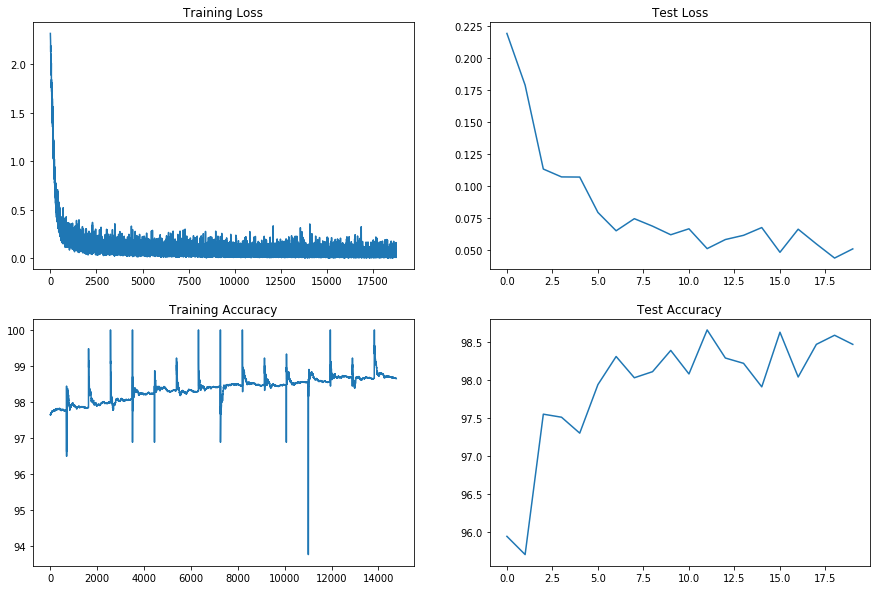

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy") 